In [1]:
import numpy as np 
import pandas as pd 
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples,silhouette_score
import matplotlib.pyplot as plt 
%matplotlib inline
dropout = pd.read_excel(r"C:/Users/ADMIN/Documents/Codebase/Data-science-projects/Education/data/dropout.xls")


In [2]:
print("\n Correlation between dropout rates at different stages of schooling\n")
dropout[['PRIMARY_TOTAL', 'UPPER_PRIMARY_TOTAL', 'SECONDARY_TOTAL','HRSECONDARY_TOTAL']].corr().style.background_gradient(cmap='RdBu')


 Correlation between dropout rates at different stages of schooling



,PRIMARY_TOTAL,UPPER_PRIMARY_TOTAL,SECONDARY_TOTAL,HRSECONDARY_TOTAL
PRIMARY_TOTAL,1.000000,0.786048,0.228586,-0.165536
UPPER_PRIMARY_TOTAL,0.786048,1.000000,0.471399,-0.084944
SECONDARY_TOTAL,0.228586,0.471399,1.000000,-0.063669
HRSECONDARY_TOTAL,-0.165536,-0.084944,-0.063669,1.000000


In [3]:
states=[]
for i in range(36):
    states.append(dropout.STATE_UT.iloc[3*i])
states=pd.DataFrame(states, columns=['State'])
dropout.drop(['STATE_UT','YEAR'],axis=1,inplace=True)
x=pd.DataFrame()
for i in range(36):
    x[i]=dropout.iloc[3*i+0:i*3+3,:].mean()
x=x.transpose()    

In [4]:
def create_clusters(x):

    scores=[]
    for i in range(4,36):
        k=KMeans(n_clusters=i,n_init=500, max_iter=500)
        k.fit(x[['PRIMARY_TOTAL', 'UPPER_PRIMARY_TOTAL', 'SECONDARY_TOTAL','HRSECONDARY_TOTAL']])
        label=KMeans.predict(k,x[['PRIMARY_TOTAL', 'UPPER_PRIMARY_TOTAL', 'SECONDARY_TOTAL','HRSECONDARY_TOTAL']])
        scores.append(silhouette_score(x, label))

    pd.DataFrame(scores).plot()
    best_cluster_no=np.argmax(scores[2:36])+2
    plt.axvline(best_cluster_no)
    plt.text(best_cluster_no, 0.34,s=f"Max silhoutte score at n={best_cluster_no}")
    plt.xlabel("No. of clusters")
    plt.ylabel("Silhoutte score")
    kk=KMeans(n_clusters=best_cluster_no)

    kk.fit(x[['PRIMARY_TOTAL', 'UPPER_PRIMARY_TOTAL', 'SECONDARY_TOTAL','HRSECONDARY_TOTAL']])
    lab = pd.DataFrame(kk.labels_,columns=['Labels'])
    result=pd.concat([states['State'],x,lab['Labels']],axis=1)
    return result

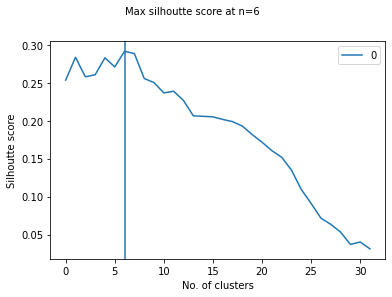

In [5]:
result=create_clusters(x)

In [8]:
grouping=result[['State','Labels']]
clusters=pd.DataFrame()
for l in grouping.Labels.unique():
    clusters=pd.concat([clusters,pd.Series(np.array(grouping.State[grouping.Labels==l]), name=f"Cluster {l}").to_frame()],axis=1)
clusters.replace({np.nan:'-'},inplace=True)
clusters.sort_index(axis=1, inplace=True)    
clusters

In [6]:
reqd=result.groupby('Labels')[result.columns[1:-1]].agg('mean')
reqd['Average dropout'] = (reqd['HRSECONDARY_TOTAL']+reqd['SECONDARY_TOTAL']+reqd['UPPER_PRIMARY_TOTAL']+reqd['PRIMARY_TOTAL'])/4
reqd.sort_values(['Average dropout'], ascending=False).style.background_gradient(cmap='Greens')

,PRIMARY_BOYS,PRIMARY_GIRLS,PRIMARY_TOTAL,UPPER_PRIMARY_BOYS,UPPER_PRIMARY_GIRLS,UPPER_PRIMARY_TOTAL,SECONDARY_BOYS,SECONDARY_GIRLS,SECONDARY_TOTAL,HRSECONDARY_BOYS,HRSECONDARY_GIRLS,HRSECONDARY_TOTAL,Average dropout
Labels,,,,,,,,,,,,,
2,10.330000,9.690556,10.010000,8.924444,9.190556,9.053889,23.383333,24.190556,23.773889,4.001667,3.218889,3.513889,11.587917
1,2.216667,1.985556,2.084444,3.525556,3.204444,3.210000,33.901111,33.630000,33.771111,2.826667,1.251111,1.921111,10.246667
5,4.283704,3.677037,3.983333,3.769259,4.486296,3.994444,18.491481,17.619259,18.102963,10.886667,7.921111,9.397407,8.869537
4,7.306667,7.690000,7.485556,4.790000,5.496667,5.096667,15.493333,16.441111,15.930000,1.181111,2.156667,1.543333,7.513889
3,0.326667,0.340667,0.325333,1.020667,0.943333,0.721333,7.687333,5.633333,6.725333,15.950667,9.204667,12.832667,5.151167
0,2.372667,2.242333,2.309667,1.903667,2.351000,1.936333,12.422667,10.443333,11.464333,4.115000,3.519000,3.774000,4.871083


In [9]:
result[['STATE_UT','PRIMARY_TOTAL', 'UPPER_PRIMARY_TOTAL', 'SECONDARY_TOTAL','HRSECONDARY_TOTAL','Labels']].to_csv('dropouts.csv')
clusters.to_csv('dropouts_clusters.csv')